In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!pip install contractions -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.8 MB/s eta 0:00:00


In [13]:
import contractions
import re
import unicodedata
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, GRU, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import matplotlib.pyplot as plt

import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function

import pandas as pd

import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [6]:
# Graph to plot history

def f_plot_history( history, file_to_save ):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 5),  constrained_layout=True)

  # plot accuracy subplot
  ax = axes[0]
  ax.plot(epochs, acc, 'b--', label='Training acc')
  ax.plot(epochs, val_acc, 'r-o', label='Validation acc')
  ax.set_title('Training and validation accuracy')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Accuracy')
  ax.legend()
  ax.grid()
  #ax.set_ylim(0,1)
  ax.legend()

  # plot loss subplot
  ax = axes[1]
  ax.plot(epochs, loss, 'b--', label='Training loss')
  ax.plot(epochs, val_loss, 'r-o', label='Validation loss')
  ax.set_title('Training and validation loss')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.legend()
  ax.grid()
  ax.legend()

  plt.savefig( file_to_save, dpi=400 )
  plt.show()


  return plt


def f_create_dir( pathOut ):
    if not os.path.exists( pathOut ):
        os.makedirs( pathOut )

# Function for preprocessing
def f_preprocess_text(text):
    text = contractions.fix(text)
    text = unicodedata.normalize('NFC', text.lower())
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

# Settings

In [4]:
ExpID = "PPv1-CNN"
num_epochs = 10
batch_size = 32
embedding_dim = 100
max_words = 10000
max_sequence_length = 100


fileIn_Train = "/content/drive/MyDrive/MSDS NLP/MS-DS-NLP demo/Task 1/Binarylabel_Train.csv"

fileIn_Val = "/content/drive/MyDrive/MSDS NLP/MS-DS-NLP demo/Task 1/Binarylabel_Val.csv"

fileIn_Test = "/content/drive/MyDrive/MSDS NLP/MS-DS-NLP demo/Task 1/Binarylabel_Test - Competition.csv"

pathSave_main_Results = "/content/drive/MyDrive/MSDS NLP/Demo-Results"
f_create_dir(pathSave_main_Results)


pathSave_trained_models = "/content/drive/MyDrive/MSDS NLP/Demo-Models"
f_create_dir(pathSave_trained_models)

In [8]:
# Load datasets

df_Train = pd.read_csv( fileIn_Train, index_col=None )

df_Val = pd.read_csv( fileIn_Val, index_col=None )

df_Test = pd.read_csv( fileIn_Test, index_col=None )

print( df_Train.shape, df_Val.shape, df_Test.shape )

print( df_Train.keys() )

df_Train["text"].head()

(1957, 3) (653, 3) (653, 3)
Index(['unique_id', 'text', 'label'], dtype='object')


,text
0,Part of what makes good writing is having smal...
1,"I’m trying to get into Freelance writing, but ..."
2,I have since sold my phone and obviously have ...
3,Sure it was almost 3 years ago (in July) two m...
4,We met and it went really well - he's a super ...


In [ ]:
# Preprocess text

df_Train["text"] = df_Train["text"].apply( lambda x: f_preprocess_text(x) )

df_Val["text"] = df_Val["text"].apply( lambda x: f_preprocess_text(x) )

df_Test["text"] = df_Test["text"].apply( lambda x: f_preprocess_text(x) )


df_Train["text"].head()

In [16]:
text_Train = df_Train["text"].tolist()
Labs_Train = df_Train["label"].tolist()

text_Val = df_Val["text"].tolist()
Labs_Val = df_Val["label"].tolist()

text_Test = df_Test["text"].tolist()

# Convert labels to categorical
Labs_Train_cat = to_categorical( Labs_Train, num_classes=2 )
Labs_Val_cat = to_categorical( Labs_Val, num_classes=2 )


In [17]:
print( len(text_Train), len(text_Val), len(text_Test) )

print( sum(Labs_Train)/len(text_Train), sum(Labs_Val)/len(text_Val) )

1957 653 653
0.20746039856923862 0.20673813169984687


# TF-IDF + Linear SVM Classifier

In [22]:
vectorizer = TfidfVectorizer(lowercase=False, max_features=10000)

Feats_Train = vectorizer.fit_transform(text_Train)
Feats_Val = vectorizer.transform( text_Val )
Feats_Test = vectorizer.transform( text_Test )

print( Feats_Train.shape, Feats_Val.shape, Feats_Test.shape )

LinearSVC_clf = LinearSVC(C=1e-5, class_weight="balanced", max_iter=1000, random_state=0)

LinearSVC_clf.fit(Feats_Train, Labs_Train)

predLabs_Val =  LinearSVC_clf.predict(Feats_Val)
acc_Val = sklearn.metrics.accuracy_score(Labs_Val, predLabs_Val)

predLabs_Test = LinearSVC_clf.predict(Feats_Test)

# - Store these predictions in the test partition template file
df_Test_TFIDFLinearSVC = df_Test.copy()

df_Test_TFIDFLinearSVC["label"] = predLabs_Test

df_Test_TFIDFLinearSVC.to_excel( "/content/TeamABC__Binarylabel_Test - Competition__Attempt 1.xlsx", index=False )



(1957, 10000) (653, 10000) (653, 10000)


In [ ]:
Labs_Val.shape

(12654,)

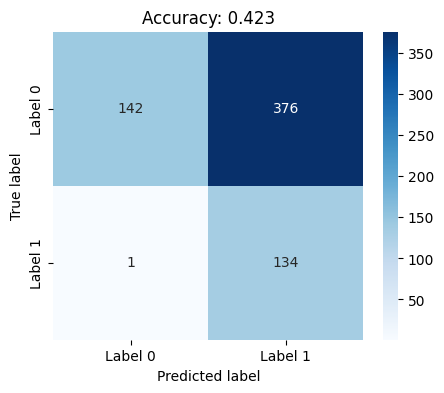




              precision    recall  f1-score   support

     Label 0       0.99      0.27      0.43       518
     Label 1       0.26      0.99      0.42       135

    accuracy                           0.42       653
   macro avg       0.63      0.63      0.42       653
weighted avg       0.84      0.42      0.43       653



In [24]:
#### Confusion matrix and classifier report for Val
cm = confusion_matrix(Labs_Val, predLabs_Val)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ["Label 0", "Label 1"],
                     columns = ["Label 0", "Label 1"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Accuracy: {0:.3f}'.format(accuracy_score(Labs_Val, predLabs_Val)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig( pathSave_main_Results+"/ConfMat_Val_TFIDF__"+ExpID+".png", dpi=400 )
plt.show()

print("\n\n")
print(classification_report(Labs_Val, predLabs_Val, target_names=["Label 0", "Label 1"]))

In [ ]:
predLabs_Test.shape

(2000,)

# Keras Tokenize

In [26]:

# Create a tokenizer object and fit it on the training data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text_Train)

# Convert the text data to sequences of integers
sequences_Train = tokenizer.texts_to_sequences(text_Train)
sequences_Val = tokenizer.texts_to_sequences(text_Val)
sequences_Test = tokenizer.texts_to_sequences(text_Test)


# Tokenization and Padding
# Pad the sequences to a fixed length using the pad_sequences function
padded_seq_Train = pad_sequences(sequences_Train, maxlen=max_sequence_length)
padded_seq_Val = pad_sequences(sequences_Val, maxlen=max_sequence_length)
padded_seq_Test = pad_sequences(sequences_Test, maxlen=max_sequence_length)

# Verify the shape of the padded sequences
print("Shape of padded_Train:", padded_seq_Train.shape)
print("Shape of padded_Val:", padded_seq_Val.shape)
print("Shape of padded_Test:", padded_seq_Test.shape)

Shape of padded_Train: (1957, 100)
Shape of padded_Val: (653, 100)
Shape of padded_Test: (653, 100)


# Custom Embedding with Dense

In [31]:
# Define the size of the vocabulary, which will be used to encode the text

modelname = "KerasEmbCNN"

input_shape = (padded_seq_Train.shape[1],)

# Define the model architecture
model = Sequential()

# Add an Embedding layer to the model, which will learn a dense vector representation of the words
# The input_dim parameter should be set to the size of the vocabulary
# The output_dim parameter specifies the size of the dense vector representation
# The input_length parameter should be set to the maximum length of the input sequences
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=input_shape ))

# Add a CNN layer
model.add( Conv1D( filters=32, kernel_size=5, activation='relu') )
model.add( Conv1D( filters=64, kernel_size=5, activation='relu') )
model.add( Conv1D( filters=128, kernel_size=5, activation='relu') )
model.add( GlobalMaxPooling1D() )

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping and model checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
model_checkpoint = ModelCheckpoint(pathSave_trained_models+"/"+modelname+'_best_model_{val_accuracy:.4f}.h5', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')


# Train the model
history = model.fit(padded_seq_Train, Labs_Train_cat,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(padded_seq_Val, Labs_Val_cat),
                    callbacks=[early_stop, model_checkpoint],
                    verbose=1)

# Load the saved best model
model = load_model(pathSave_trained_models+"/"+modelname+"_best_model_"+"{:.4f}".format(model_checkpoint.best)+".h5")

# Evaluate the model on the test data
#test_loss, test_acc = model.evaluate(padded_seq_Test, Labs_Test_cat)
#print('Test accuracy:', test_acc)

# Evaluate the model on the test data
#test_loss, test_acc = model.evaluate(padded_seq_Test, Labs_Test_cat)
#print('Test accuracy:', test_acc)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7654 - loss: 0.6026
Epoch 1: val_accuracy improved from -inf to 0.79326, saving model to /content/drive/MyDrive/MSDS NLP/Demo-Models/KerasEmbCNN_best_model_0.7933.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7661 - loss: 0.6013 - val_accuracy: 0.7933 - val_loss: 0.4936
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7900 - loss: 0.5132
Epoch 2: val_accuracy did not improve from 0.79326
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7901 - loss: 0.5128 - val_accuracy: 0.7933 - val_loss: 0.4804
Epoch 3/10
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7976 - loss: 0.3656
Epoch 3: val_accuracy did not improve from 0.79326
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7974 - loss: 0.3657 - val_accuracy: 0.7933 - val_loss: 0.5148
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7982 - loss: 0.3023
Epoch 4: val_accuracy did not improve from 0.79326
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7987 - loss: 0.3021 - val_accuracy: 0.7351 - val_loss: 0.6561
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9272 - loss: 0.2022
Epoch 5: val_accuracy did not improve from 

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 32)         │        16,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 92, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 88, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,077,828 (4.11 MB)

 Trainable params: 1,077,826 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

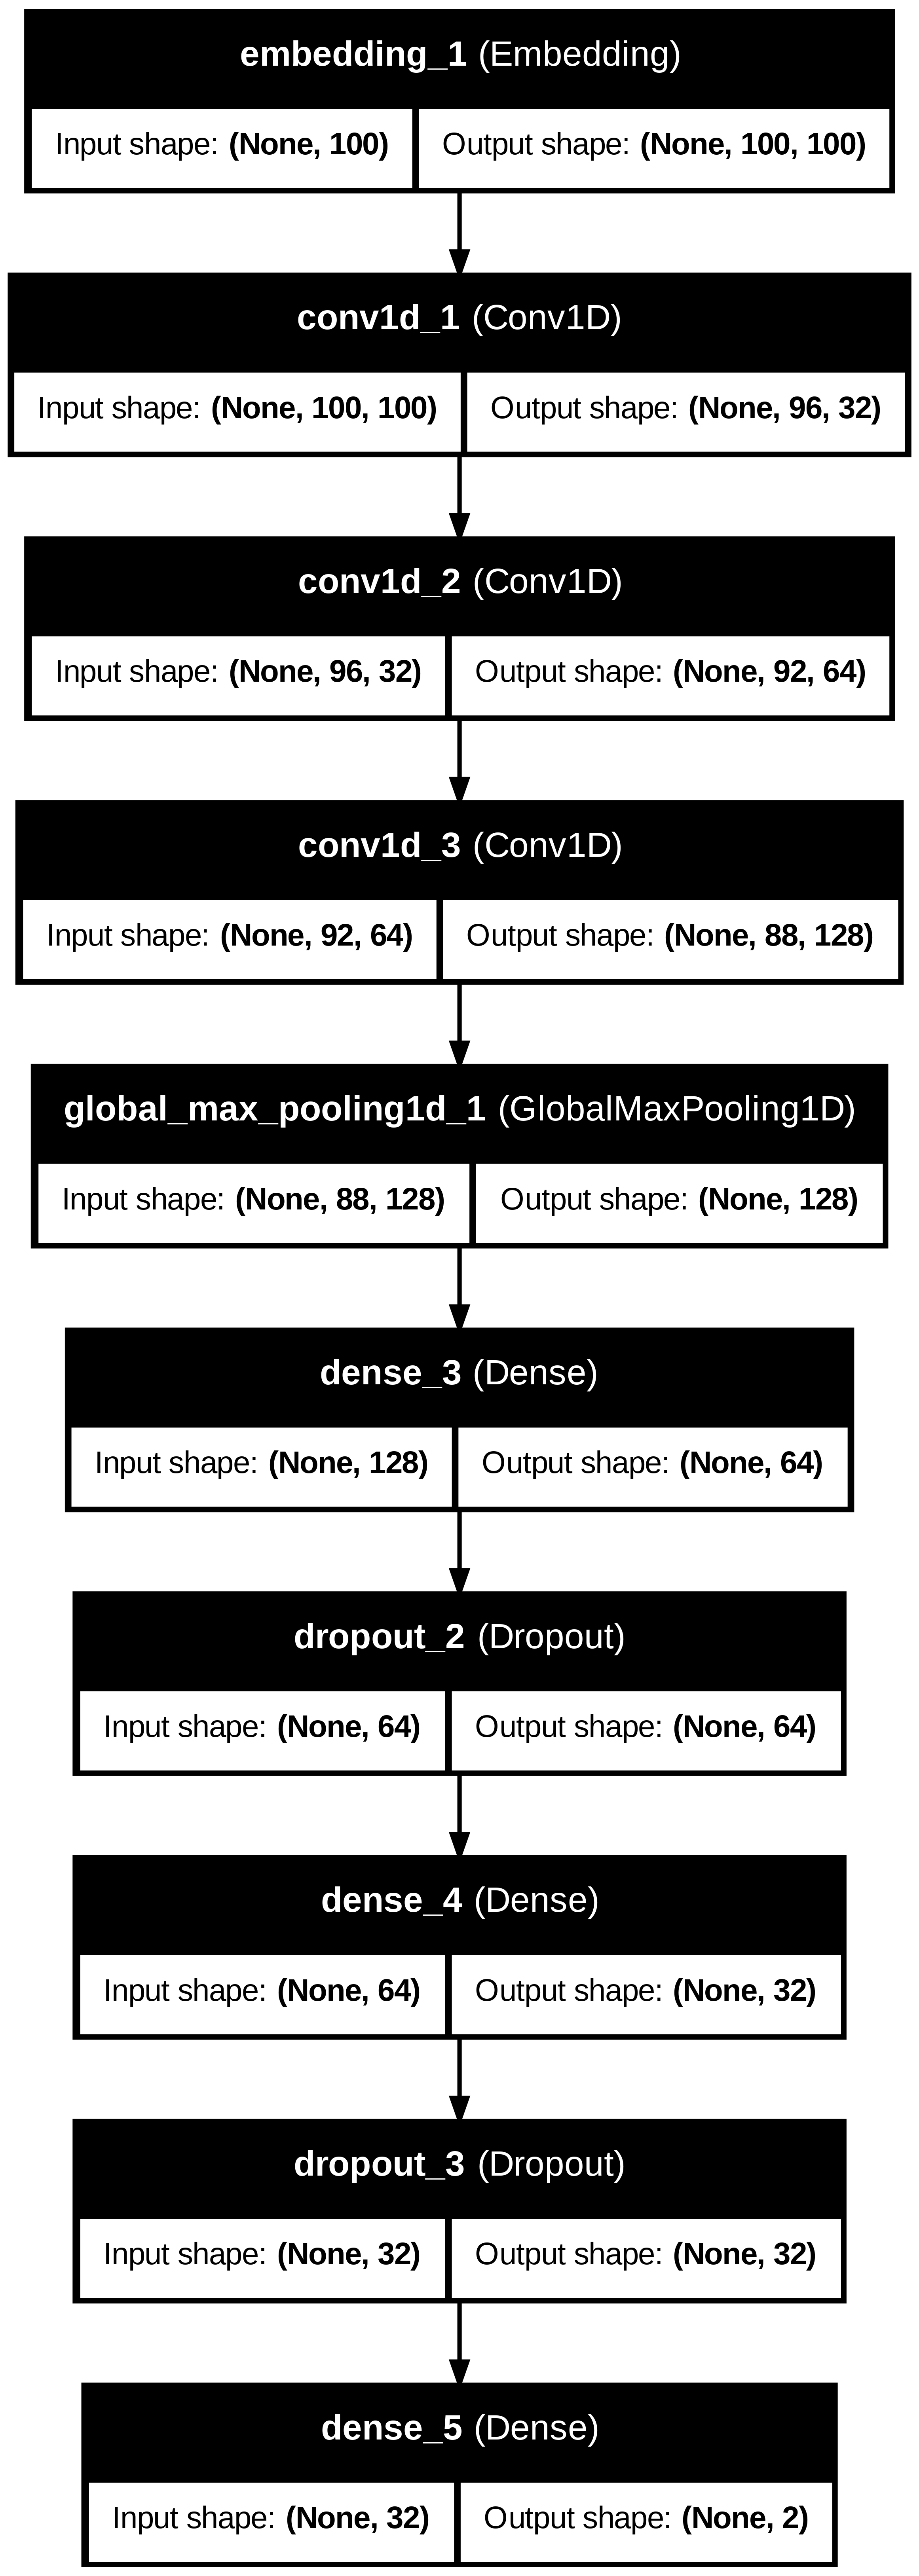

In [33]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='/content/CNN_v2.png', show_shapes=True, show_layer_names=True, dpi=400 )

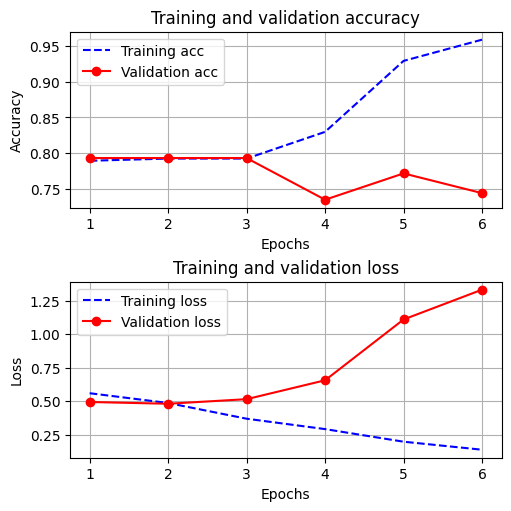

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [34]:
f_plot_history( history, pathSave_main_Results+"/DLTrainValCurve_KerasEmbDense__"+ExpID+".png" )

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


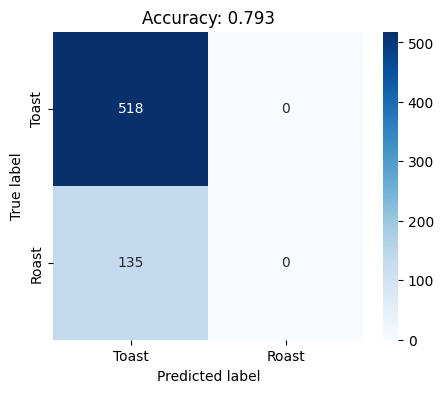




              precision    recall  f1-score   support

       Toast       0.79      1.00      0.88       518
       Roast       0.00      0.00      0.00       135

    accuracy                           0.79       653
   macro avg       0.40      0.50      0.44       653
weighted avg       0.63      0.79      0.70       653



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
#### Confusion matrix and classifier report for Val

predLabs_Val = np.argmax( model.predict(padded_seq_Val), axis=1)

cm = confusion_matrix(Labs_Val, predLabs_Val)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ["Toast", "Roast"],
                     columns = ["Toast", "Roast"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Accuracy: {0:.3f}'.format(accuracy_score(Labs_Val, predLabs_Val)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig( pathSave_main_Results+"/ConfMat_Val_KerasEmbDense__"+ExpID+".png", dpi=400 )
plt.show()

print("\n\n")
print(classification_report(Labs_Val, predLabs_Val, target_names=["Toast", "Roast"]))

In [36]:
# - Store these predictions in the test partition template file
df_Test_KerasEmbCNN_v2 = df_Test.copy()

df_Test_KerasEmbCNN_v2["label"] = predLabs_Test

df_Test_KerasEmbCNN_v2.to_excel( "/content/TeamABC__Binarylabel_Test - Competition__Attempt 3.xlsx", index=False )

